# Mediapipe Feature Extraction


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/Intelligent System Project/archive.zip' -d "/content"

In [ ]:
!pip install mediapipe

## Loading images

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import keras
import datetime

BASE_DIR = '/content/drive/MyDrive/Intelligent System Project/'
TRAIN_DIR = "archive/asl_alphabet_train/asl_alphabet_train/"
LABELS = list(filter(lambda x: x not in [".DS_Store", "nothing"], sorted(os.listdir(TRAIN_DIR))))
LABEL_LIMIT = 3000

IMAGE_SIZE = (128, 128)
IMAGE_DEPTH = (3,)

LOG_DIR = BASE_DIR + "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

In [ ]:
# Helper function
import random
def load_images():

    images = []
    labels = []
    for idx, label in enumerate(LABELS):
        np.random.seed(idx)
        array = np.random.randint(1, 3000, size = LABEL_LIMIT)
        if os.path.isfile(TRAIN_DIR + label): continue
        for val in array:
            filepath = f"{TRAIN_DIR}{label}/{label}{val}.jpg"
            image = cv2.resize(cv2.imread(filepath), IMAGE_SIZE)
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return (images, labels)

images, labels = load_images()

## Feature extraction

In [16]:
import mediapipe as mp
import cv2
import pandas as pd

mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.2)

def extract_mediapipe_features(image, label, index):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = mp_hands.process(image_rgb)
    landmarks = results.multi_hand_landmarks

    features = []
    if landmarks:
        for hand_landmarks in landmarks:
            for landmark in hand_landmarks.landmark:
                features.append([label, index, landmark, landmark.x, landmark.y, landmark.z])

    return features

if os.path.exists(BASE_DIR + "mediapipe_features.csv"):
  df = pd.read_csv(BASE_DIR + "mediapipe_features.csv")
else:
  mediapipe_features = []

  for index, (image, label) in enumerate(zip(images, labels)):
      image_features = extract_mediapipe_features(image, label, index)
      mediapipe_features.extend(image_features)

  df = pd.DataFrame(mediapipe_features, columns=['Letter', 'id', 'landmark', 'x', 'y', 'z'])

In [ ]:
df.to_csv(BASE_DIR + "mediapipe_features.csv")

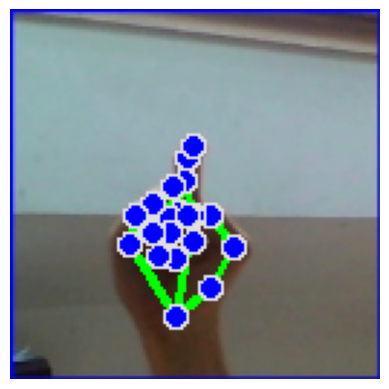

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def draw_landmarks_on_image(rgb_image):
    mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)
    results = mp_hands.process(rgb_image)
    landmarks = results.multi_hand_landmarks

    if landmarks is not None:
        landmark_drawing_spec = mp.solutions.drawing_utils.DrawingSpec(thickness=2, color=(0, 0, 255))

        for hand_landmarks in landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                rgb_image,
                hand_landmarks,
                mp.solutions.hands.HAND_CONNECTIONS,
                landmark_drawing_spec,
                mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 0))
            )

    return rgb_image


image = random.choice(images)
image_resized = cv2.resize(image, IMAGE_SIZE)
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

image_with_landmarks = draw_landmarks_on_image(image_rgb)

plt.imshow(image_with_landmarks)
plt.axis('off')
plt.show()


# Visualizing and balancing the dataset

In [ ]:
import numpy as np

df = df[df["Letter"] != 27] # We filter out the "nothing" label
df['Letter'] = df['Letter'].replace(28, 27)
label_to_letter = {index: letter for index, letter in enumerate(LABELS)}

df_copy = df.copy()
df_copy['landmark'] = df_copy.groupby(['id', 'Letter']).cumcount()

melted_df = df_copy.melt(id_vars=['id', 'Letter', 'landmark'], value_vars=['x', 'y', 'z'],
                         var_name='coordinate', value_name='value')

melted_df['landmark_coordinate'] = 'landmark_' + melted_df['landmark'].astype(str) + '_' + melted_df['coordinate']

final_df = melted_df.pivot_table(index=['id', 'Letter'],
                                 columns='landmark_coordinate',
                                 values='value',
                                 aggfunc='first').reset_index()

final_df.columns = [col if col == 'Letter' else col.lower() for col in final_df.columns]

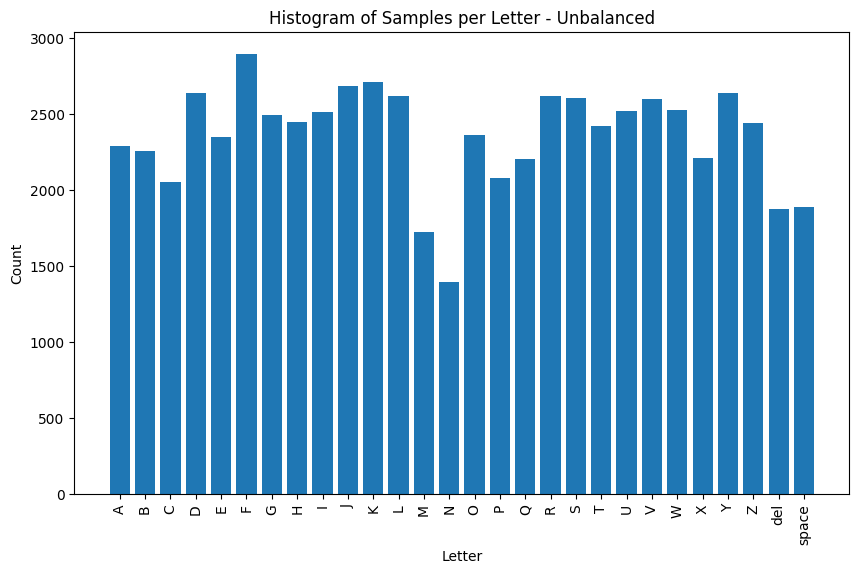

In [ ]:
def plot_histogram(dataframe, title):
  samples_per_letter = dataframe.groupby(["Letter"]).size().reset_index(name="Count")

  plt.figure(figsize=(10, 6))
  plt.bar(np.arange(len(samples_per_letter)), samples_per_letter["Count"])
  plt.xlabel("Letter")
  plt.ylabel("Count")
  plt.title("Histogram of Samples per Letter - " + title)
  plt.xticks(np.arange(len(samples_per_letter)), [label_to_letter[index] for index in samples_per_letter["Letter"]], rotation=90)
  plt.show()

plot_histogram(final_df, "Unbalanced")

In [19]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

X = final_df.drop('Letter', axis=1)
y = final_df['Letter']

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)
smote_df = pd.DataFrame(X_sm)
smote_df["Letter"] = y_sm

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)
rus_df = pd.DataFrame(X_rus)
rus_df["Letter"] = y_rus


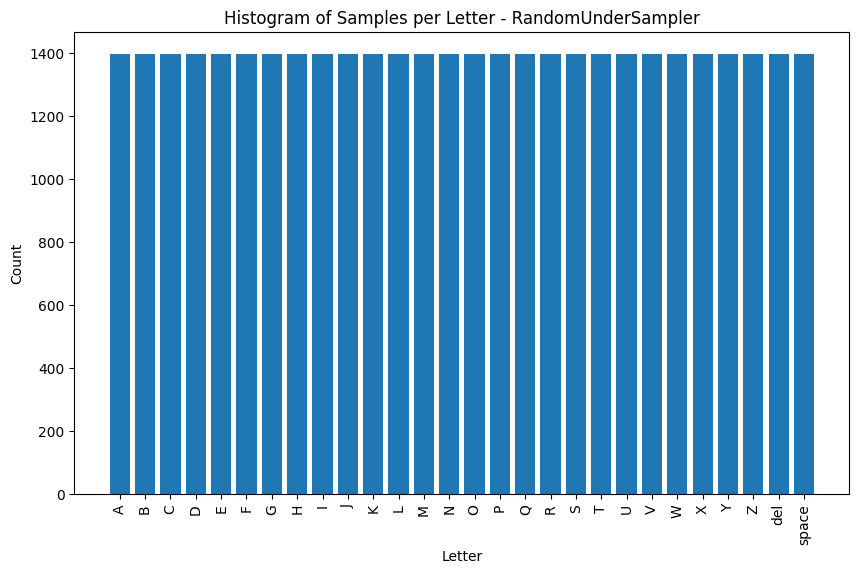

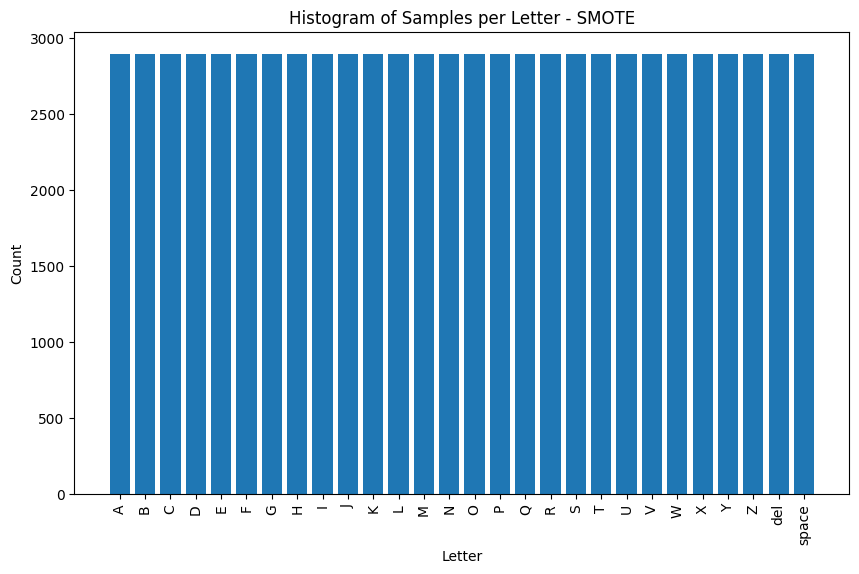

In [ ]:
plot_histogram(rus_df, "RandomUnderSampler")
plot_histogram(smote_df, "SMOTE")

# Mediapipe-assisted Classifier

In [ ]:
INPUT_UNITS = 128
HIDDEN_UNITS = 64
OUTPUT_UNITS = len(pd.unique(y))

EPOCHS = 40
BATCH_SIZE = 64

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def build_model(input_dim):
  model = Sequential()
  model.add(Dense(INPUT_UNITS, input_dim = input_dim, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(HIDDEN_UNITS, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(OUTPUT_UNITS, activation = 'softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

def plot_loss(history, name):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  plt.figure()
  plt.plot(val_loss,'o-b', label='validation loss')
  plt.title('val_loss')
  plt.plot(loss,'o-r', label='train loss')
  plt.title('loss - ' + name)
  plt.legend()
  plt.show()

def landmark_key(col_name):
    if col_name.startswith("landmark"):
        split_name = col_name.split('_')
        return (int(split_name[1]), split_name[2])
    else:
        return (-1, '')

In [ ]:
from sklearn.model_selection import train_test_split

df_names = ["Unbalanced", "SMOTE", "RandomUnderSampler"]
models = []
histories = []
for dataframe, name in zip([final_df, smote_df, rus_df], df_names):
  X = dataframe.drop(columns=['Letter'])
  X.drop(X.columns[:1], axis=1, inplace=True) # Dropping the image id
  y = dataframe['Letter']

  cols = X.columns.tolist()
  cols_sorted= sorted(cols, key = landmark_key)
  X = X[cols_sorted]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
  model = build_model(X_train.shape[1])
  history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=EPOCHS)
  models.append(model)
  histories.append(history)

Epoch 1/40
1240/1240 [==============================] - 5s 3ms/step - loss: 1.6759 - accuracy: 0.5155 - val_loss: 0.5322 - val_accuracy: 0.8802
Epoch 2/40
1240/1240 [==============================] - 4s 3ms/step - loss: 0.5482 - accuracy: 0.8408 - val_loss: 0.3113 - val_accuracy: 0.9307
Epoch 3/40
1240/1240 [==============================] - 4s 3ms/step - loss: 0.3679 - accuracy: 0.8963 - val_loss: 0.2180 - val_accuracy: 0.9527
Epoch 4/40
1240/1240 [==============================] - 4s 3ms/step - loss: 0.2981 - accuracy: 0.9165 - val_loss: 0.1957 - val_accuracy: 0.9555
Epoch 5/40
1240/1240 [==============================] - 4s 3ms/step - loss: 0.2577 - accuracy: 0.9285 - val_loss: 0.1789 - val_accuracy: 0.9557
Epoch 6/40
1240/1240 [==============================] - 4s 3ms/step - loss: 0.2381 - accuracy: 0.9334 - val_loss: 0.1601 - val_accuracy: 0.9597
Epoch 7/40
1240/1240 [==============================] - 4s 3ms/step - loss: 0.2192 - accuracy: 0.9378 - val_loss: 0.1611 - val_accuracy:

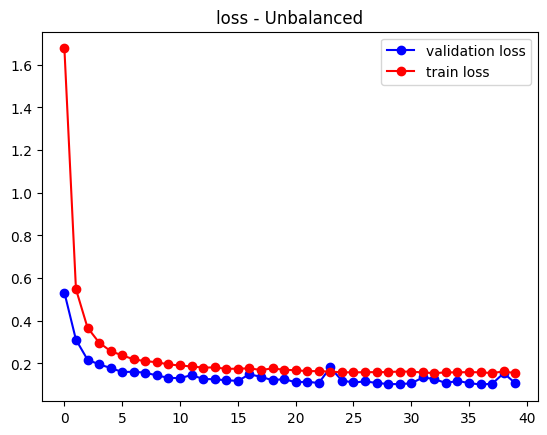

245/245 [==============================] - 1s 2ms/step - loss: 0.1060 - accuracy: 0.9729
Model performance - Unbalanced [0.10595820844173431, 0.9729211926460266]


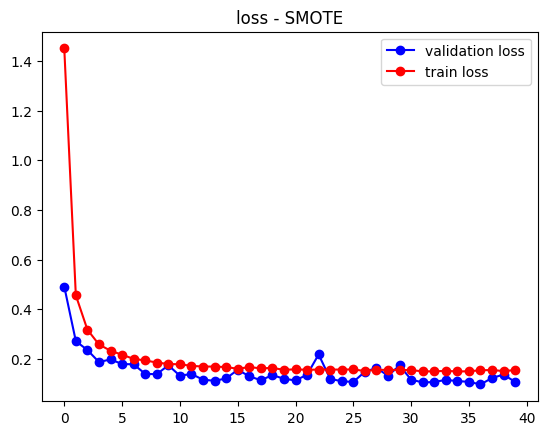

245/245 [==============================] - 0s 2ms/step - loss: 0.0947 - accuracy: 0.9770
Model performance - SMOTE [0.09471762925386429, 0.977008581161499]


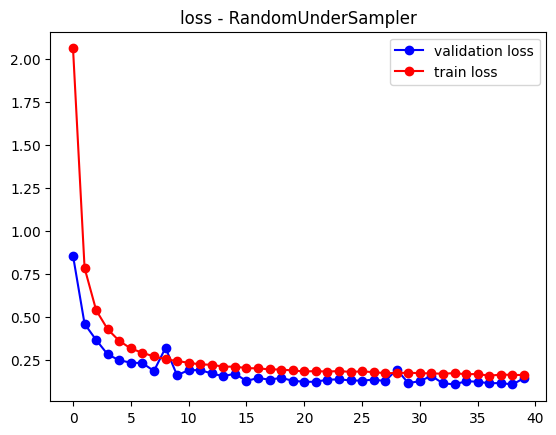

245/245 [==============================] - 0s 2ms/step - loss: 0.1351 - accuracy: 0.9563
Model performance - RandomUnderSampler [0.13505251705646515, 0.9563162326812744]


In [ ]:
for m, h, n in zip(models, histories, df_names):
  plot_loss(h, n)
  print(f"Model performance - {n}", m.evaluate(X_test, y_test))
  m.save(f"{BASE_DIR}models/{n}.h5", save_format = 'h5')